In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import ipywidgets as widgets

%matplotlib widget
%load_ext autoreload
%autoreload 2


max y: 9.065512657165527 at x=80.16032064128257


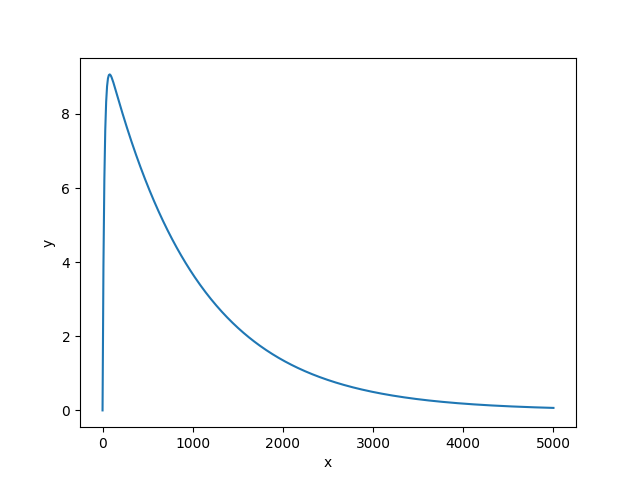

In [3]:
linspace = np.linspace(0, 5000, 500)
x = torch.tensor(linspace, requires_grad=False)
y1 = (-10 * 0.95 ** x).float()
y2 = (10 * 0.999 ** x).float()
y = y1 + y2

fig, ax = plt.subplots()
ax.plot(linspace, y.numpy())
ax.set_xlabel('x')
ax.set_ylabel('y')
print(f"max y: {y.max()} at x={linspace[y.argmax()]}")


In [4]:
# batch, player, position(x, y)
team = torch.tensor([[[1, 2], [3, 4]], [[7, 8], [9, 10]]]).float()
target = (1, 2)
target_torch = torch.tensor(target).repeat(team.shape[0], 1).unsqueeze(1).float()
print(team.shape, target_torch.shape)

norm = torch.norm(team - target_torch, dim=2)
print(norm)

torch.Size([2, 2, 2]) torch.Size([2, 1, 2])
tensor([[ 0.0000,  2.8284],
        [ 8.4853, 11.3137]])


In [5]:
torch.mean(norm, dim=1)

tensor([1.4142, 9.8995])

In [6]:
scaling = (norm)
foo = scaling * norm
foo_sum = foo.sum(dim=1).unsqueeze(1)
print(foo_sum)
print(norm)
print(norm*foo_sum)

tensor([[  8.0000],
        [200.0000]])
tensor([[ 0.0000,  2.8284],
        [ 8.4853, 11.3137]])
tensor([[   0.0000,   22.6274],
        [1697.0560, 2262.7415]])


In [7]:
num_frequencies =5
freq_bands = torch.linspace(1.0, 2 ** (num_frequencies - 1), num_frequencies)
print(freq_bands)

tensor([ 1.0000,  4.7500,  8.5000, 12.2500, 16.0000])


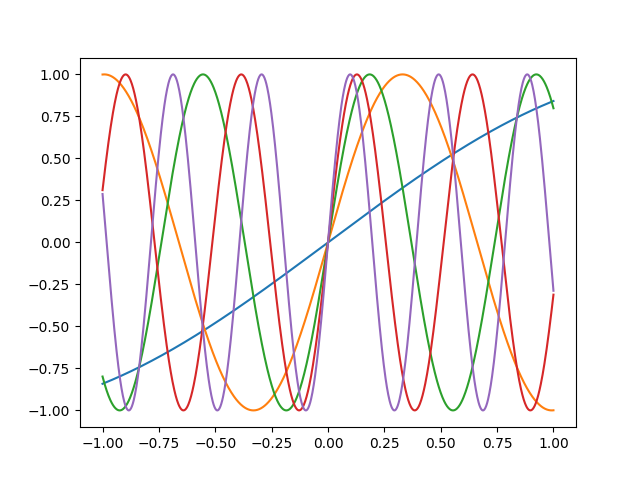

In [8]:
nums = torch.linspace(-1, 1, 1000)
fig, ax = plt.subplots()
for i in range(num_frequencies):
    ax.plot(nums, torch.sin(nums * freq_bands[i]).numpy())

plt.show()

In [9]:
import train 
model = train.train(players_per_team=1, 
        epochs=10000, 
        load_model=True,
        loss_fn=train.ball_to_target_loss
)

/home/arty/seegoals/controller/venv/lib/python3.11/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


15

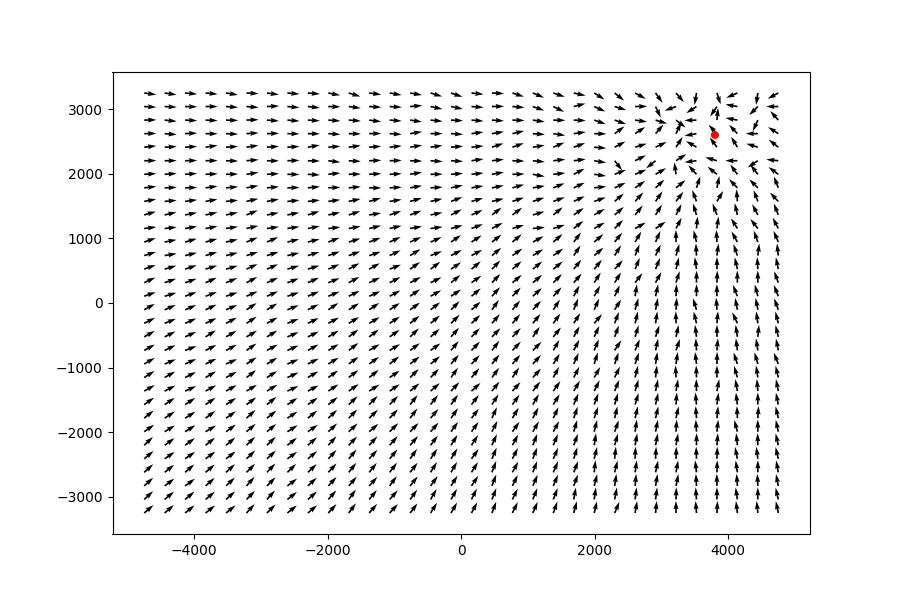

In [10]:
samples = 32
x, y = torch.meshgrid(torch.linspace(-0.5, 0.5, samples), torch.linspace(-0.5, 0.5, samples))
x = x.flatten()
y = y.flatten()
field_hight = 9500
field_width = 6500
scale = torch.tensor([field_hight, field_width]).float()

team = torch.stack([x, y], dim=1).unsqueeze(1) * scale
enemy = torch.stack([y, x], dim=1).unsqueeze(1) * scale

ball = torch.tensor([0.4, 0.4]).float().repeat(team.shape[0], 1).unsqueeze(1) * scale

delta = model(team, enemy, ball).squeeze(1).detach().numpy()
# norm_delta = delta / torch.norm(delta, dim=1).unsqueeze(1)


fig, ax = plt.subplots(figsize=(9, 6))
# when a click is detected of fig, the mouse position is sent to the model
def on_mose_click(event):
    global delta
    x = event.xdata
    y = event.ydata
    # print(x, y)
    ball = torch.tensor([x, y]).float().repeat(team.shape[0], 1).unsqueeze(1)
    # old_delta = delta.copy()
    delta = model(team, enemy, ball).squeeze(1).detach().numpy()
    # print(np.linalg.norm(delta - old_delta))
    ax.clear()
    
    ax.quiver(team[:, 0, 0], team[:, 0, 1], delta[:, 0], delta[:, 1])

    circle = plt.Circle([x, y], 50, color='r')
    ax.add_artist(circle)
    fig.canvas.draw()


ax.quiver(team[:, 0, 0], team[:, 0, 1], delta[:, 0], delta[:, 1])
circal = plt.Circle(ball[0, 0], 50, color='r')
ax.add_artist(circal)
fig.canvas.mpl_connect('button_press_event', on_mose_click)




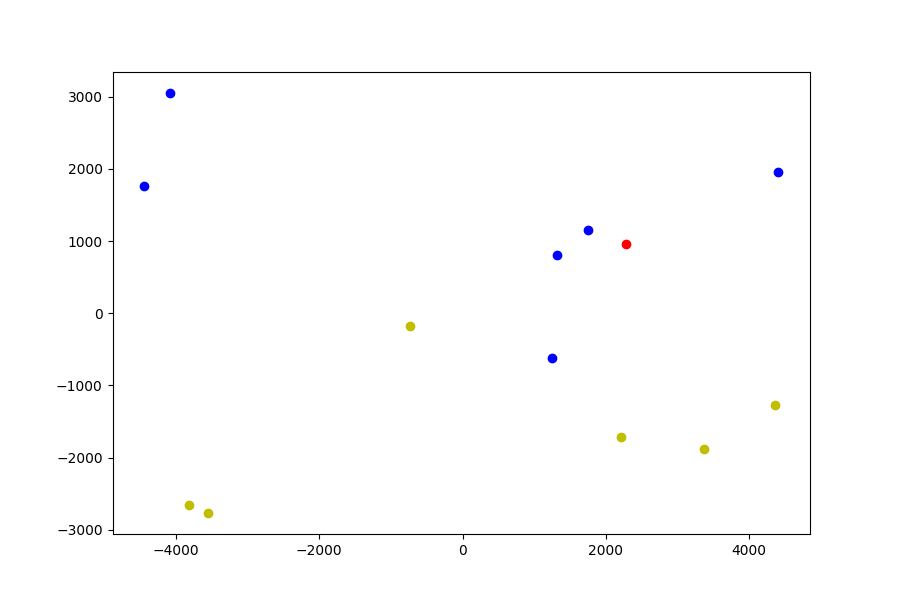

In [11]:
team_size = 6
yellow_team = (torch.rand((1, team_size, 2)) - 0.5) * scale
blue_team = (torch.rand((1, team_size, 2)) - 0.5) * scale
ball = (torch.rand((1, 1, 2)) - 0.5) * scale

fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(yellow_team[0, :, 0], yellow_team[0, :, 1], color='y')
ax.scatter(blue_team[0, :, 0], blue_team[0, :, 1], color='b')
ax.scatter(ball[0, 0, 0], ball[0, 0, 1], color='r')

plt.show()

In [12]:
import json, pathlib


PATH = "Downloads/2024-07-21_11-57_ELIMINATION_PHASE_UBC_Thunderbots-vs-Ri-one.log.txt"
HOME = pathlib.Path.home()
PATH = HOME / PATH
with open(PATH, 'r', encoding='utf-8') as f:
    content = f.readlines()
    data = [json.loads(line) for line in content]
print(len(data))


153199


In [13]:
class Ball:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __repr__(self):
        return f"Ball({self.x}, {self.y})"

class Robot:
    def __init__(self, id, x, y, angle):
        self.id = id
        self.x = x
        self.y = y
        self.angle = angle
    
    def __repr__(self):
        return f"Robot{self.id}({self.x}, {self.y}, {self.angle})"

class GameState:
    def __init__(self,state):
        self.ball = Ball(state['balls'][0]['x'], state['balls'][0]['y'])
        self.team_size = 6
        self.yellow_team = {r['robot_id']: Robot(r['robot_id'], r['x'], r['y'], r['orientation']) for r in state['robots_yellow']}
        self.blue_team = {r['robot_id']: Robot(r['robot_id'], r['x'], r['y'], r['orientation']) for r in state['robots_blue']}

    def __repr__(self):
        return f"GameState(\n  {self.ball},\n  {self.yellow_team},\n  {self.blue_team})"
    
    def to_tensor(self):
        yellow_team = torch.tensor([[r.x, r.y] for r in sorted(self.yellow_team.values(), key=lambda r: r.id)]) 
        blue_team = torch.tensor([[r.x, r.y] for r in sorted(self.blue_team.values(), key=lambda r: r.id)])
        
        ball = torch.tensor([self.ball.x, self.ball.y])
        return yellow_team, blue_team, ball

state = data[0]

game_states = [GameState(state) for state in data if 'balls' in state and 'robots_yellow' in state and 'robots_blue' in state]


138025


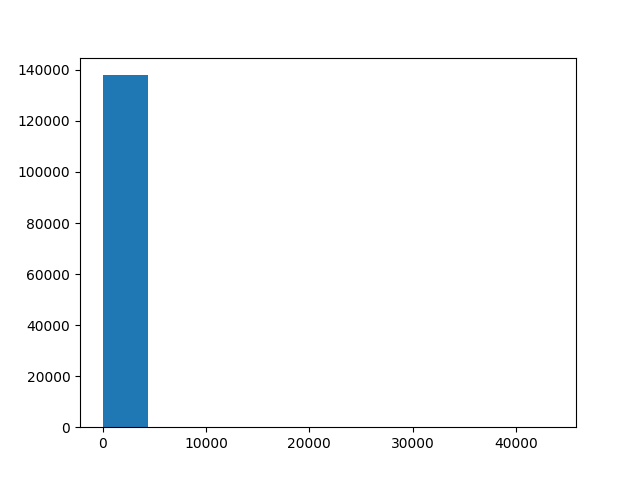

In [14]:
print(len(game_states))
def dist(state1, state2):
    ball_dist = np.linalg.norm([state1.ball.x - state2.ball.x, state1.ball.y - state2.ball.y])
    yellow_dist = 0
    for robot in state1.yellow_team.values():
        if robot.id in state2.yellow_team:
            robot2 = state2.yellow_team[robot.id]
            yellow_dist += np.linalg.norm([robot.x - robot2.x, robot.y - robot2.y])
    blue_dist = 0
    for robot in state1.blue_team.values():
        if robot.id in state2.blue_team:
            robot2 = state2.blue_team[robot.id]
            blue_dist += np.linalg.norm([robot.x - robot2.x, robot.y - robot2.y])
    total_dist = ball_dist + yellow_dist + blue_dist
    return total_dist

distances = [dist(state1, state2) for state1, state2 in zip(game_states, game_states[1:])]

fig, ax = plt.subplots()
ax.hist(distances, bins=10)

plt.show()



4362 138025


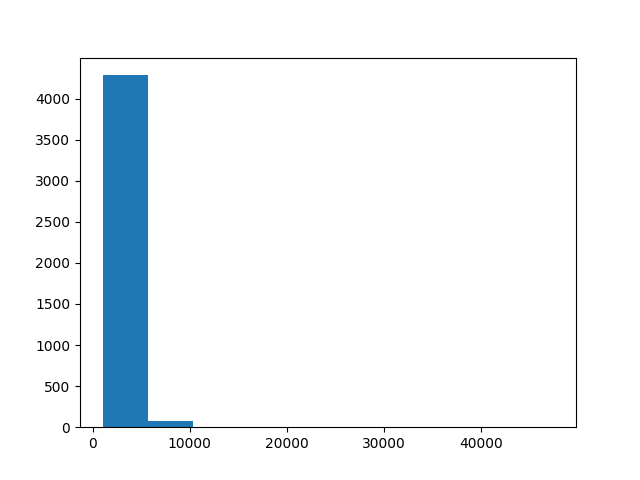

In [15]:
game_states_trimmed = []
max_dist = 1000

for i, state in enumerate(game_states):
    if i == 0:
        game_states_trimmed.append(state)
    else:
        if dist(game_states_trimmed[-1], state) > max_dist:
            game_states_trimmed.append(state)
print(len(game_states_trimmed), len(game_states))

distances = [dist(state1, state2) for state1, state2 in zip(game_states_trimmed, game_states_trimmed[1:])]

fig, ax = plt.subplots()
ax.hist(distances, bins=10)

plt.show()

GameState(
  Ball(-4.5200286, -4.8467107),
  {4: Robot4(-1028.7422, -1548.74, 0.29390466), 7: Robot7(-948.42914, -0.8251368, 0.017064733), 0: Robot0(-1261.4767, 1304.4061, -0.07749128), 1: Robot1(-4346.8906, 4.0549765, -0.016539028), 2: Robot2(-3245.499, 297.87494, -0.064383194)},
  {3: Robot3(3216.4934, 73.057365, 3.030529), 4: Robot4(3247.4846, -204.31958, 3.1144598), 0: Robot0(4356.933, 11.58762, -3.1028643), 1: Robot1(658.0318, -819.40356, -3.0513642), 2: Robot2(581.5944, -1524.066, -2.7090156), 6: Robot6(920.2271, 1654.305, 2.8185897)})


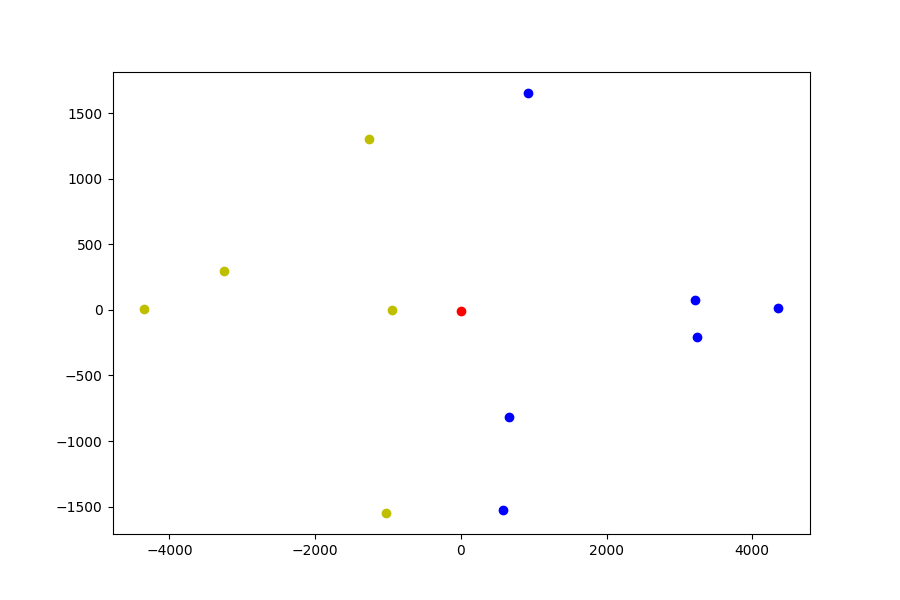

In [16]:

game_state = game_states[0]
print(game_state)

yellow_team, blue_team, ball = game_state.to_tensor()
fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(yellow_team[:, 0], yellow_team[:, 1], color='y')
ax.scatter(blue_team[:, 0], blue_team[:, 1], color='b')
ax.scatter(ball[0], ball[1], color='r')

plt.show()

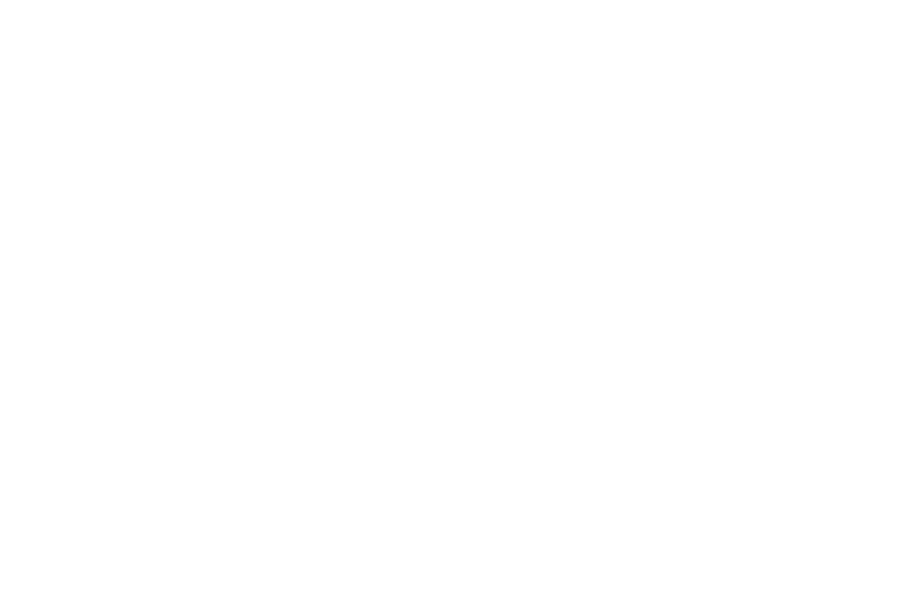

In [19]:
# animation
import matplotlib.animation as animation
fig, ax = plt.subplots(figsize=(9, 6))
yellow_team, blue_team, ball = game_states_trimmed[0].to_tensor()
yellow_team = yellow_team.numpy()
blue_team = blue_team.numpy()
ball = ball.numpy()
yellow_team_plot = ax.scatter(yellow_team[:, 0], yellow_team[:, 1], color='y')
blue_team_plot = ax.scatter(blue_team[:, 0], blue_team[:, 1], color='b')
ball_plot = ax.scatter(ball[0], ball[1], color='r')
ax.set_ylim(-field_width/2, field_width/2)
ax.set_xlim(-field_hight/2, field_hight/2)
samples = len(game_states_trimmed)
def update(frame):
    print(f"{frame/samples*100:.2f}%", end='\r')
    yellow_team, blue_team, ball = game_states_trimmed[frame].to_tensor()
    yellow_team = yellow_team.numpy()
    blue_team = blue_team.numpy()
    ball = ball.numpy()
    yellow_team_plot.set_offsets(yellow_team[:, :2])
    blue_team_plot.set_offsets(blue_team[:, :2])
    ball_plot.set_offsets(ball[:2])
    return yellow_team_plot, blue_team_plot, ball_plot

ani = animation.FuncAnimation(fig, update, frames=samples, blit=True)
ani.save('game.mp4', writer='ffmpeg', fps=30)
plt.clf()